<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Compare-AQI" data-toc-modified-id="Compare-AQI-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Compare AQI</a></span></li><li><span><a href="#A-Dataset-Object" data-toc-modified-id="A-Dataset-Object-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>A Dataset Object</a></span><ul class="toc-item"><li><span><a href="#Compiling-pollution-data" data-toc-modified-id="Compiling-pollution-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Compiling pollution data</a></span></li></ul></li><li><span><a href="#Geography" data-toc-modified-id="Geography-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Geography</a></span></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data Exploration</a></span></li><li><span><a href="#Analyze-Fire-activities" data-toc-modified-id="Analyze-Fire-activities-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analyze Fire activities</a></span><ul class="toc-item"><li><span><a href="#Number-of-Hotspots-by-Country" data-toc-modified-id="Number-of-Hotspots-by-Country-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Number of Hotspots by Country</a></span></li><li><span><a href="#Landuse-on-the-hotspots" data-toc-modified-id="Landuse-on-the-hotspots-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Landuse on the hotspots</a></span></li><li><span><a href="#Amount-of-repeating-hotspots" data-toc-modified-id="Amount-of-repeating-hotspots-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Amount of repeating hotspots</a></span></li><li><span><a href="#Fire-Activities-Per-Country-Over-the-Year" data-toc-modified-id="Fire-Activities-Per-Country-Over-the-Year-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Fire Activities Per Country Over the Year</a></span></li></ul></li></ul></div>

In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
import src
from src.imports import *
from src.gen_functions import *
# import the Dataset object class
from src.features.dataset import Dataset
# import all the function for visuliazation
from src.visualization.vis_data import *
from src.features.landuse import add_countries, label_landuse_fire

#set bokeh output
output_notebook()
# change plt font size
plt.rcParams.update({'font.size': 14})

Loading BokehJS ...

# Compare AQI

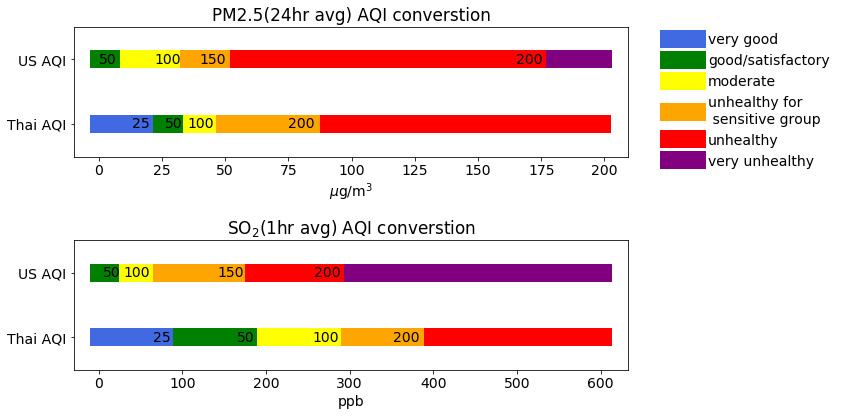

In [4]:
compare_aqis(filename='../reports/chiang_mai/aqi.png')

# A Dataset Object

It is more convenience to have a `Dataset` object that keep tracks of all relavant data for a city along with necessary meta information such as city location etc. This is object is under `src.features.dataset.py`.

The `Dataset` object is also in charge of compile raw pollution, weather, fire data from the data folder into a ready-to-use format using `dataset.build_all_data()`. The processed data are saved under ../data/city_name/. The code below illustrates how to `Dataset` object compile the data using a build_all_data command. This object also keep track of feature engineering parameters during the model optimization step[notebook](https://github.com/worasom/aqi_thailand2/blob/master/notebooks/5.0-ML_ChiangMai.ipynb). For the Dataset object's documentation, please refer to https://github.com/worasom/aqi_thailand2/blob/master/docs/_build/html/src.features.html.

In [ ]:
# init a dataset object and build the data from scratch 
# only perform this when new data files are added 
dataset = Dataset('Chiang Mai')

# build pollution,  weather data and (optional) fire data
dataset.build_all_data( build_fire=True, build_holiday=True)

th_stations ['35t', '36t']
Averaging data from 3 stations
Loading all hotspots data. This might take sometimes


`dataset.build_all_data()` calls four functions: 
- `dataset.build_pollution()`: compiles pollution data form all available sources, averages all the pollution data, and add as `dataset.poll_df` attribute. 
- `dataset.build_weather()`: load weather data, fills the missing, and add as `dataset.wea`.
- `dataset.build_fire()`: Compile the satellite data files into a `dataset.fire` dataframe.
- `dataset.build_holiday()`: scrapes holiday information from the website and save as a csv file. 
    
These function can be called separately when needing to update any data.

After the building process, which might take sometimes because of the size of the fire data (building the fire data is optional and can be set to false (`build_fire=False`). The complied data can be loaded using `_load()` command.

In [2]:
# load saved process data 
dataset = Dataset('Chiang Mai')
dataset.load_()

The hourly pollution data, weather data, and fire data are under `dataset.poll_df`, `dataset.wea` and `dataset.fire` attributes accordingly. Each data is a panda dataframe with datetime index. For example, the pollution data for Chiang Mai looks like

In [48]:
print(dataset.poll_df.tail(2).to_markdown())

| datetime            |   PM2.5 |   PM10 |   O3 |   CO |   NO2 |   SO2 |
|:--------------------|--------:|-------:|-----:|-----:|------:|------:|
| 2020-06-17 15:00:00 |     8.5 |   19.5 |   15 | 0.4  |     5 |     1 |
| 2020-06-17 16:00:00 |     7.5 |   16.5 |   11 | 0.43 |     5 |     1 |


Additionally the dataset also has city information under `city_info` attribute

In [27]:
dataset.city_info

{'Country': 'Thailand',
 'City': 'Chiang Mai',
 'City (ASCII)': 'Chiang Mai',
 'Region': 'Chiang Mai',
 'Region (ASCII)': 'Chiang Mai',
 'Population': '200952',
 'Latitude': '18.7904',
 'Longitude': '98.9847',
 'Time Zone': 'Asia/Bangkok',
 'lat_km': 2117.0,
 'long_km': 11019.0}

## Compiling pollution data

`dataset.build_pollution()` compiles data from many data sources and average them into a single dataframe under `dataset.poll_df` attribute. Internally, this function calls `dataset.collect_stations_data()` for a list of pollution dataframes from different sources. It calls many functions in `src.data.read_data.py`. Here, I will explain `dataset.collect_stations_data()` function. 

Below is the definition of this function

In [ ]:
    def collect_stations_data(self):
        """Collect all Pollution data from a different sources and take the average.

        Since each city have different data sources. It has to be treat differently. 
        The stations choices is specified by the config.json

        Returns: a list of dataframe each dataframe is the data from all station.

        """
        # data list contain the dataframe of all pollution data before merging
        # all of this data has 'datetime' as a columns
        data_list = []

        # load data from Berkeley Earth Projects This is the same for all cities
        b_data, _ = read_b_data(self.main_folder + 'pm25/' + self.city_name.replace(' ', '_') + '.txt')
        data_list.append(b_data)

        try:
            # load config_dict for the city 
            config_dict = self.config_dict[self.city_name]
        except:
            config_dict = {}
        
        # load thailand stations if applicable 
        if 'th_stations' in config_dict.keys():
            station_ids = config_dict['th_stations']
            print('th_stations', station_ids)
            self.merge_new_old_pollution(station_ids)
            # load the file
            for station_id in station_ids:
                filename = self.data_folder + station_id + '.csv'
                data = pd.read_csv(filename)
                data['datetime'] = pd.to_datetime(data['datetime'])
                data_list.append(data)
        # load the Thailand stations maintained by cmucdc project 
        if 'cmu_stations' in config_dict.keys():
            station_ids = config_dict['cmu_stations']
            print('cmu_stations', station_ids)
            for station_id in station_ids:
                filename = self.main_folder + 'cdc_data/' + str(station_id) + '.csv' 
                data_list.append(read_cmucdc(filename))
        
        if 'b_stations' in config_dict.keys():
            # add Berkeley stations in near by provinces 
            station_ids = config_dict['b_stations']
            print('add Berkerley stations', station_ids)
            for station_id in station_ids:
                b_data, _ = read_b_data(self.main_folder + 'pm25/' + f'{station_id}.txt')
                data_list.append(b_data)

        if 'us_emb' in config_dict.keys():
            # add the data from US embassy 
            print('add US embassy data')
            data_list += build_us_em_data(city_name=self.city_name,
                                                    data_folder=f'{self.main_folder}us_emb/')

        return data_list 

`src.data.read_data.read_b_data()` loads the [Berkeley project](http://berkeleyearth.org/) data using the `self.city_name`. This data is common for all the cities. For the other data sources, the availability varies, so it must be specified in `src.features.config.py`. The dictionary in this function is added as `dataset.conf_dict` attribute. 

For example for **Chiang Mai**, it says 

In [66]:
print('Chiang Mai stations ', dataset.config_dict )

Chiang Mai stations  {'th_stations': ['35t', '36t']}


This means that for Chiang Mai, include the data form two Thailand DPC stations: '35t', '36t', in addition to the Berkeley project data. The function dataset.merge_new_old_pollution() compiled the historical data and scraped data for each station and save under `../data/city_name/` folder. The merged data is then read and append to the data_list. 

For **Nakhon Si Thammarat**, the config_dict says

In [69]:
print('Nakhon Si Thammarat', dataset.config_dict )

Nakhon Si Thammarat {'th_stations': ['42t', 'm3'], 'cmu_stations': [118]}


For Nakhon Si Thammarat, I borrow the data from the near by province (station '42t'), in addition to the mobile station 'm3'. Then I also include the data from [Chiang Mai University Monitoring Stations](https://www.cmuccdc.org/), station number 118. This is done by calling `src.data.read_data.read_cmucdc()`

To check for Thailand DPC's stations number, use `src.data.read_data.get_th_stations().

In [75]:
src.data.read_data.get_th_stations('Chiang Mai')

(['35t', '36t'],
 [{'stationID': '35t',
   'nameTH': 'ศูนย์ราชการจังหวัดเชียงใหม่ ',
   'nameEN': 'City Hall, Chiangmai',
   'areaTH': 'ต.ช้างเผือก อ.เมือง, เชียงใหม่',
   'areaEN': 'Chang Phueak, Meuang, Chiang Mai',
   'stationType': 'GROUND',
   'lat': '18.840633',
   'long': '98.969661',
   'LastUpdate': {'date': '2020-09-17',
    'time': '23:00',
    'PM25': {'value': '15', 'unit': 'µg/m³'},
    'PM10': {'value': '27', 'unit': 'µg/m³'},
    'O3': {'value': '18', 'unit': 'ppb'},
    'CO': {'value': '-', 'unit': 'ppm'},
    'NO2': {'value': '0', 'unit': 'ppb'},
    'SO2': {'value': '0', 'unit': 'ppb'},
    'AQI': {'Level': '1', 'aqi': '15'}}},
  {'stationID': '36t',
   'nameTH': 'โรงเรียนยุพราชวิทยาลัย ',
   'nameEN': 'Yupparaj Wittayalai School',
   'areaTH': 'ต.ศรีภูมิ อ.เมือง, เชียงใหม่',
   'areaEN': 'Si Phum, Meuang, Chiang Mai',
   'stationType': 'GROUND',
   'lat': '18.7909205',
   'long': '98.9881062',
   'LastUpdate': {'date': '2020-09-17',
    'time': '23:00',
    'PM25': 

For [Chiang Mai University Monitoring Stations](https://www.cmuccdc.org/), one can search for the station ids from their json file. For example,

In [87]:
station_info_list = requests.get('https://www.cmuccdc.org/api/ccdc/stations').json()

station_ids= []
for station in station_info_list:
    if 'Nakhon Si Thammarat' in station['dustboy_name_en']:
        station_ids.append(station['dustboy_id'])

print(station_ids)

['118']


For **Hanoi**, the configuration file says

In [68]:
print('Hanoi stations ', dataset.config_dict)

Hanoi stations  {'b_stations': ['Ha_Dong'], 'us_emb': True}


This means that for Hanoi also includes the data form a near by city 'Ha_Dong' from Berkeley project, and also the data from US Embassy in Hanoi [US Embassy](http://dosairnowdata.org/dos/historical/).  Therefore, `src.data.read_data.read_b_data()` for Ha Dong is called, and `src.data.read_data.build_us_em_data()` for Hanoi is called. 

# Geography

I have two handy functions to convert logtitude, latitude coordinates to Mercator projection and vice versa. They are `src.gen_functions.merc_x`, `src.gen_functions.merc_y`, and `src.gen_functions.to_latlon`

In [6]:
# Location of power plants
plant1 = [18.291836, 99.747635, 'coal']
plant2 = [19.199594, 97.981650, 'diesel']
plant3 = [18.188042, 97.934958, 'diesel']
plant4 = [16.629450, 99.870301, 'natural gas']

plant_list = [plant1[:2], plant2[:2], plant3[:2], plant4[:2]]
plant_list = [plant1, plant2, plant3, plant4]

plant_list = np.vstack(plant_list)
plant_x = merc_x(plant_list[:,1].astype(float))
plant_y = [merc_y(y) for y in  plant_list[:,0]]

In [7]:
# location of industrial complex 
industrial_loc = [18.595537, 99.044438]
ind_x = merc_x(industrial_loc[1])
ind_y = merc_y(industrial_loc[0])

In [8]:
# load city center from the dataset object and convert to mercator
city_x = merc_x(dataset.city_info['Longitude'])
city_y = merc_y(dataset.city_info['Latitude'])

In [12]:
# load Thailand PCD station locations for Chiang Mai
# this information is stored in the raw data folder

# load station information file 
aqm_folder = '../data/aqm_hourly2/'
# load stations information for air4 Thai
station_info_file = aqm_folder + 'stations_locations.json'
with open(station_info_file, 'r',encoding="utf8") as f:
    station_info = json.load(f)
station_info = station_info['stations']

In [15]:
# load Thailand PCD station locations for Chiang Mai
# this information is stored in the raw data folder

# load station information file 
aqm_folder = '../data/aqm_hourly2/'
# load stations information for air4 Thai
station_info_file = aqm_folder + 'stations_locations.json'
with open(station_info_file, 'r',encoding="utf8") as f:
    station_info = json.load(f)
station_info = station_info['stations']

# Chiang mai station ids
cm_station_ids = ['35t', '36t']

cm_station_coor = []
for station in station_info:
    if station['stationID'] in cm_station_ids:
        lat = merc_y(station['lat'])
        long = merc_x(station['long'])
        cm_station_coor.append([lat, long])
cm_station_coor = np.array(cm_station_coor)

In [17]:
# set the size of the map 
stepx = 2E5
stepy = stepx

# range bounds supplied in web mercator coordinates
p = figure(x_range=(city_x-stepx,city_x+1.2*stepx), y_range=(city_y-stepy*0.5, city_y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'Power Plants and Industrical Site')
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))
p.scatter(plant_x,plant_y,color='red',line_color='black',size=10, legend_label='power plants')

p.circle(ind_x, ind_y,color='blue',line_color='black',size=10, legend_label='industrial complex')

p.scatter(cm_station_coor[:,1],cm_station_coor[:,0],color='magenta', line_color='black',size=10, legend_label='PCD stations')


show(p)
export_png(p, filename='C:/Users/Benny/Documents/Fern/aqi_thailand2/reports/chiang_mai/cm_map.png')

'C:\\Users\\Benny\\Documents\\Fern\\aqi_thailand2\\reports\\chiang_mai\\cm_map.png'

# Data Exploration

In [18]:
# Extract the pollution data 
poll_df = dataset.poll_df
city_name = dataset.city_name

Index(['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'SO2'], dtype='object')


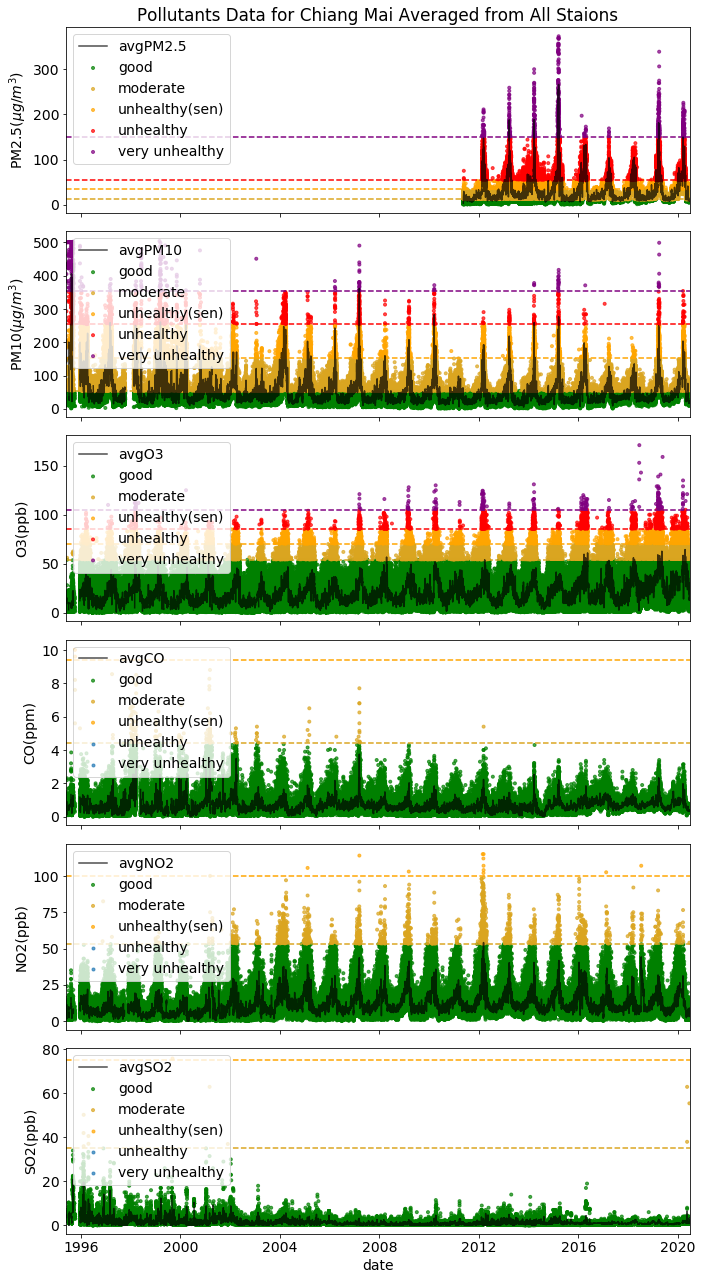

In [19]:
# looking at the raw data
plot_all_pollutions(poll_df, city_name=city_name)

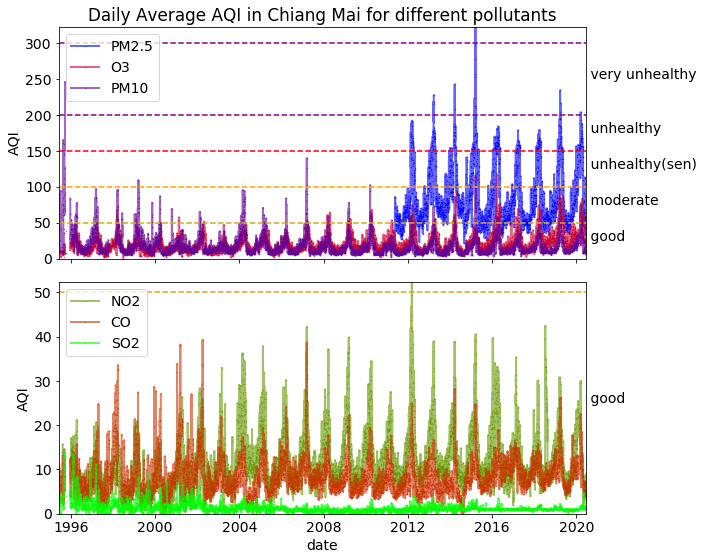

In [11]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

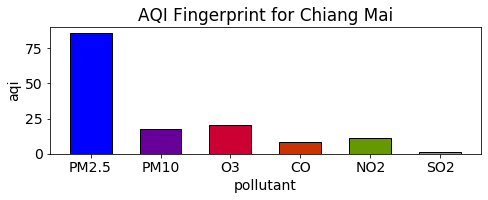

In [23]:
plot_chem_print(poll_to_aqi(dataset.poll_df.copy(), dataset.roll_dict).mean(axis=0), dataset.city_name, filename=dataset.report_folder + 'fingerprint.png')

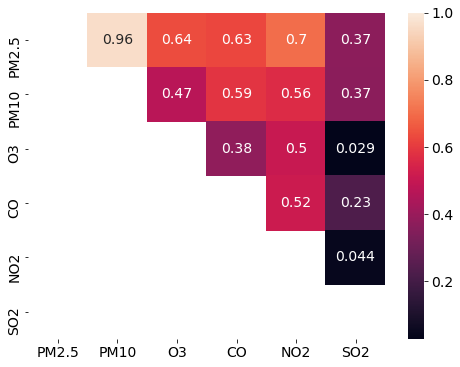

In [21]:
# understanding Pearson correlation between data. I use spearman
plot_corr(dataset.poll_df.resample('d').mean(), filename=dataset.report_folder+'poll_corr.png')

aqi 100 in  12-13 to 05-11
aqi 150 in  02-21 to 04-21


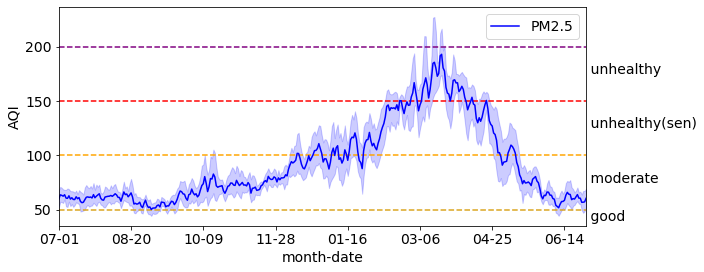

In [14]:
plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25_aqi.png')

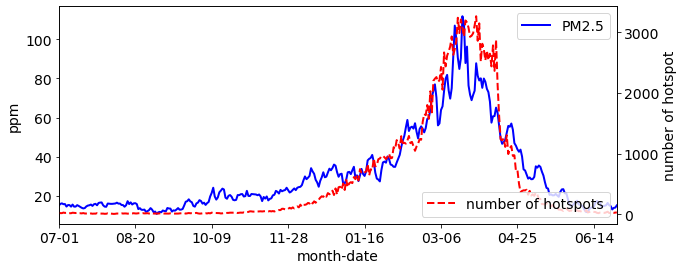

In [79]:
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
#poll_aqi = poll_to_aqi(data.poll_df.copy(), data.roll_dict)
winter_day_dict, mean_day = plot_season_avg(dataset.poll_df.copy(), 'PM2.5', ax, plot_error=False, roll=True, agg='mean',linewidth=2 )

ax.set_ylabel('$\mu g/m^3$')
ax1 = ax.twinx()
fire_hour = dataset.fire[['count']].resample('d').sum()
fire_hour.columns = ['number of hotspots']
winter_day_dict, fire_mean_day = plot_season_avg(fire_hour.copy(), 'number of hotspots', ax1, plot_error=False, roll=False, agg='mean',color='red',linestyle='dashed',linewidth=2)

ax1.legend(loc='lower right')
ax1.set_ylabel('number of hotspot')
plt.savefig(dataset.report_folder + 'fire_PM25_season.png')

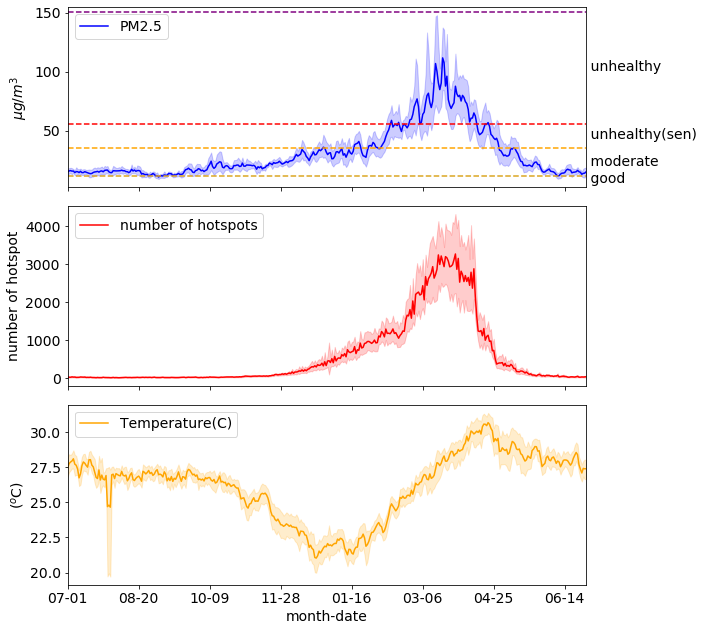

In [16]:
compare_seson_avg(dataset, wea_col=['Temperature(C)'], agg='mean', filename=dataset.report_folder + 'fire_PM25_t_season.png')

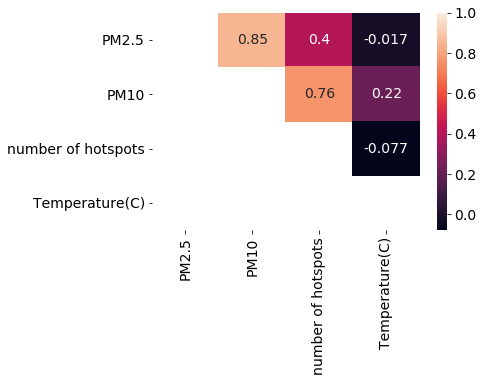

In [156]:
plot_corr(year_avg, figsize=(6,4))

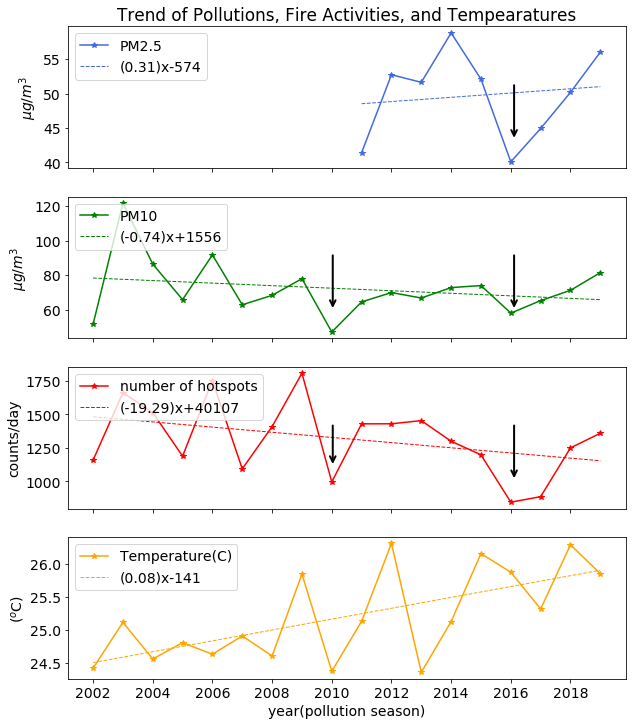

In [77]:
ax, year_avg = plot_yearly_ln(dataset)

for i, a in enumerate(ax):
    if i != 3:
        a.annotate('', xy=(0.8, 0.2),xytext=(0.8, 0.6), xycoords='axes fraction',
               horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=2))

ax[1].annotate('', xy=(0.475, 0.2),xytext=(0.475, 0.6), xycoords='axes fraction',
               horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=2))
ax[2].annotate('', xy=(0.475, 0.3),xytext=(0.475, 0.6), xycoords='axes fraction',
               horizontalalignment="center", arrowprops=dict(arrowstyle='->',lw=2))

plt.savefig(dataset.report_folder + 'compare_ln_trends.png')

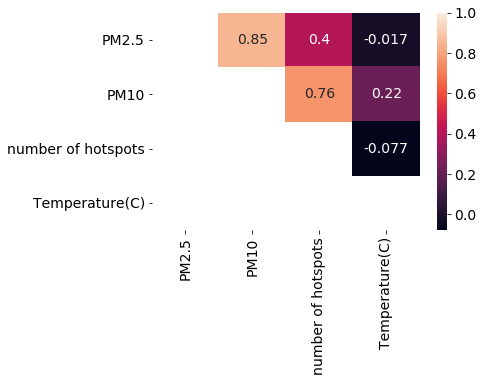

In [78]:
plot_corr(year_avg, figsize=(6,4))

# Analyze Fire activities

I try to show that the hotspots seen from satellite are from agricultural burning not wild fires. One way to do that is to overlay land use data on top of the hotspot data. Another useful information is how often the hotspots occur at the same location. A naturally occured fires would have a random location and not likely going to occur at the same location in different year. Hotspots from agricultural or man-made activities often occur at the same locations. I have to be careful about the spatial resolution of the MODIS instruments, which is 1km. So the location has to be round to 1km. 

I am going first label lanuse and add country originating the hotspots, then count the percents of the hotspots with repetition for each country. 

Two useful command are 

In [7]:
dataset = Dataset('Chiang Mai')
# label location of the fire using landuse data around chiang mai
# this command generate another file named '../data/chiang_mai/' + 'fire_m_label.csv' 
# I don't wanna save over the old file to prevent accidently save over the labeling information 
label_landuse_fire('../data/chiang_mai/' + 'fire_m.csv')

# add country hosting the fires
fire = pd.read_csv('../data/chiang_mai/' + 'fire_m_label.csv')
fire, gdf = add_countries(fire, city_xy_m=[dataset.city_info['long_m'], dataset.city_info['lat_m']])

fire.to_csv('../data/chiang_mai/' + 'fire_m_label.csv')

In [2]:
label_landuse_fire('../data/bangkok/' + 'fire_m.csv', fire_chunk=1E5)

bkk_dataset = Dataset('Bangkok')
# add country hosting the fires
fire = pd.read_csv('../data/bangkok/' + 'fire_m_label.csv')
fire, gdf = add_countries(fire, city_xy_m=[bkk_dataset.city_info['long_m'], bkk_dataset.city_info['lat_m']])

fire.to_csv('../data/bangkok/' + 'fire_m_label.csv')

0it [00:00, ?it/s]

C:/Users/Benny/Documents/Fern/aqi_thailand2/data/bangkok/fire_m.csv
C:/Users/Benny/Documents/Fern/aqi_thailand2/data/bangkok/fire_m_label.csv


1it [00:24, 24.37s/it]

2it [00:45, 23.44s/it]

3it [01:06, 22.67s/it]

4it [01:27, 22.15s/it]

5it [01:48, 21.91s/it]

6it [02:10, 21.78s/it]

7it [02:31, 21.50s/it]

8it [02:52, 21.49s/it]

9it [03:14, 21.56s/it]

10it [03:36, 21.61s/it]

11it [03:57, 21.46s/it]

12it [04:18, 21.45s/it]

13it [04:39, 21.36s/it]

14it [05:00, 21.27s/it]

15it [05:21, 21.23s/it]

16it [05:43, 21.19s/it]

17it [06:06, 21.80s/it]

18it [06:27, 21.56s/it]

19it [06:48, 21.37s/it]

20it [07:09, 21.28s/it]

21it [07:30, 21.17s/it]

22it [07:51, 21.18s/it]

23it [08:12, 21.24s/it]

24it [08:34, 21.29s/it]

25it [08:55, 21.22s/it]

26it [09:16, 21.16s/it]

27it [09:37, 21.09s/it]

28it [09:58, 21.08s/it]

29it [10:19, 21.04s/it]

30it [10:39, 20.98s/it]

31it [11:01, 20.99s/it]

32it [11:21, 20.99s/it]

33it [11:42, 20.99s/it]

34it [12:03, 20.96s/it]

35it [12:24, 20.96s/it]

36it [12:45, 20.98s/it]

37it [13:06, 20.97s/it]

38it [13:27, 21.01s/it]

39it [13:48, 20.99s/it]

40it [14:09, 20.96s/it]

41it [14:32, 21.63s/it]

42it [14:53, 21.39s/it]

43it [15:14, 21.33s/it]

44it [15:35, 21.19s/it]

45it [15:56, 21.14s/it]

46it [16:17, 21.06s/it]

47it [16:38, 21.02s/it]

48it [16:59, 21.04s/it]

49it [17:20, 21.05s/it]

50it [17:41, 21.00s/it]

51it [18:02, 21.05s/it]

52it [18:24, 21.10s/it]

53it [18:45, 21.09s/it]

54it [19:06, 21.07s/it]

55it [19:27, 21.06s/it]

56it [19:48, 21.09s/it]

57it [20:09, 21.14s/it]

58it [20:30, 21.09s/it]

59it [20:52, 21.43s/it]

60it [21:17, 22.35s/it]

61it [21:38, 22.01s/it]

62it [21:59, 21.84s/it]

63it [22:22, 21.90s/it]

64it [22:42, 21.62s/it]

65it [23:04, 21.72s/it]

66it [23:27, 22.02s/it]

67it [23:50, 22.13s/it]

68it [24:13, 22.39s/it]

69it [24:35, 22.36s/it]

70it [24:57, 22.28s/it]

71it [25:18, 22.03s/it]

72it [25:40, 21.89s/it]

73it [26:01, 21.76s/it]

74it [26:23, 21.66s/it]

75it [26:47, 22.27s/it]

76it [27:08, 22.03s/it]

77it [27:29, 21.88s/it]

78it [27:51, 21.81s/it]

79it [28:12, 21.66s/it]

80it [28:34, 21.64s/it]

81it [28:55, 21.54s/it]

82it [29:17, 21.49s/it]

83it [29:38, 21.35s/it]

84it [29:59, 21.29s/it]

85it [30:20, 21.26s/it]

86it [30:41, 21.18s/it]

87it [31:02, 21.21s/it]

88it [31:23, 21.16s/it]

89it [31:45, 21.18s/it]

90it [32:06, 21.21s/it]

91it [32:27, 21.18s/it]

92it [32:48, 21.17s/it]

93it [33:09, 21.14s/it]

94it [33:31, 21.20s/it]

95it [33:52, 21.19s/it]

96it [34:13, 21.24s/it]

97it [34:34, 21.25s/it]

98it [34:56, 21.23s/it]

99it [35:19, 21.89s/it]

100it [35:50, 24.54s/it]

101it [36:11, 23.54s/it]

102it [36:32, 22.85s/it]

103it [36:53, 22.34s/it]

104it [37:14, 21.97s/it]

105it [37:36, 21.75s/it]

106it [37:57, 21.69s/it]

107it [38:19, 21.63s/it]

108it [38:40, 21.45s/it]

109it [39:10, 24.16s/it]

110it [39:31, 23.30s/it]

111it [39:53, 22.76s/it]

112it [40:14, 22.22s/it]

113it [40:38, 22.62s/it]

114it [40:59, 22.21s/it]

115it [41:20, 21.89s/it]

116it [41:41, 21.70s/it]

117it [42:03, 21.63s/it]

118it [42:24, 21.49s/it]

119it [42:45, 21.43s/it]

120it [43:06, 21.35s/it]

121it [43:28, 21.33s/it]

122it [43:49, 21.31s/it]

123it [44:10, 21.38s/it]

124it [44:32, 21.35s/it]

125it [44:53, 21.36s/it]

126it [45:14, 21.30s/it]

127it [45:35, 21.30s/it]

128it [45:57, 21.33s/it]

129it [46:18, 21.34s/it]

130it [46:42, 22.01s/it]

131it [47:03, 21.81s/it]

132it [47:24, 21.61s/it]

133it [47:46, 21.50s/it]

134it [48:07, 21.38s/it]

135it [48:28, 21.32s/it]

136it [48:49, 21.31s/it]

137it [49:10, 21.27s/it]

138it [49:32, 21.27s/it]

139it [49:53, 21.31s/it]

140it [50:14, 21.32s/it]

141it [50:35, 21.25s/it]

142it [50:57, 21.28s/it]

143it [51:18, 21.30s/it]

144it [51:39, 21.28s/it]

145it [52:01, 21.36s/it]

146it [52:22, 21.32s/it]

147it [52:43, 21.32s/it]

148it [53:05, 21.33s/it]

149it [53:26, 21.35s/it]

150it [53:47, 21.33s/it]

151it [54:09, 21.31s/it]

152it [54:30, 21.36s/it]

153it [54:53, 21.86s/it]

154it [55:41, 29.78s/it]

155it [56:30, 35.31s/it]

156it [56:51, 31.04s/it]

157it [57:12, 28.14s/it]

158it [57:34, 26.12s/it]

159it [57:55, 24.75s/it]

160it [58:16, 23.68s/it]

161it [58:38, 23.03s/it]

162it [58:59, 22.58s/it]

163it [59:21, 22.22s/it]

164it [59:42, 21.95s/it]

165it [1:00:03, 21.80s/it]

166it [1:00:25, 21.69s/it]

167it [1:00:49, 22.28s/it]

168it [1:01:10, 21.90s/it]

169it [1:01:31, 21.74s/it]

170it [1:01:52, 21.63s/it]

171it [1:02:14, 21.52s/it]

172it [1:02:35, 21.48s/it]

173it [1:02:56, 21.39s/it]

174it [1:03:18, 21.43s/it]

175it [1:03:39, 21.45s/it]

176it [1:04:01, 21.50s/it]

177it [1:04:22, 21.39s/it]

178it [1:04:43, 21.39s/it]

179it [1:05:05, 21.37s/it]

180it [1:05:26, 21.37s/it]

181it [1:05:47, 21.29s/it]

182it [1:06:09, 21.33s/it]

183it [1:06:30, 21.36s/it]

184it [1:06:51, 21.38s/it]

185it [1:07:13, 21.34s/it]

186it [1:07:36, 21.96s/it]

187it [1:07:58, 21.82s/it]

188it [1:08:19, 21.63s/it]

189it [1:08:40, 21.56s/it]

190it [1:09:01, 21.50s/it]

191it [1:09:23, 21.42s/it]

192it [1:09:44, 21.34s/it]

193it [1:10:05, 21.37s/it]

194it [1:10:27, 21.38s/it]

195it [1:10:48, 21.34s/it]

196it [1:11:09, 21.36s/it]

197it [1:11:31, 21.41s/it]

198it [1:11:52, 21.35s/it]

199it [1:12:14, 21.38s/it]

200it [1:12:35, 21.42s/it]

201it [1:12:57, 21.47s/it]

202it [1:13:18, 21.49s/it]

203it [1:13:40, 21.51s/it]

204it [1:14:01, 21.41s/it]

205it [1:14:25, 22.17s/it]

206it [1:14:46, 21.95s/it]

207it [1:15:08, 21.79s/it]

208it [1:15:29, 21.61s/it]

209it [1:16:09, 27.11s/it]

210it [1:16:30, 25.33s/it]

211it [1:16:52, 24.17s/it]

212it [1:17:13, 23.38s/it]

213it [1:17:34, 22.74s/it]

214it [1:17:56, 22.35s/it]

215it [1:18:17, 22.08s/it]

216it [1:18:38, 21.81s/it]

217it [1:19:00, 21.75s/it]

218it [1:19:21, 21.66s/it]

219it [1:19:54, 25.00s/it]

220it [1:20:15, 23.87s/it]

221it [1:20:37, 23.14s/it]

222it [1:20:58, 22.66s/it]

223it [1:21:20, 22.27s/it]

224it [1:21:41, 22.02s/it]

225it [1:22:05, 22.50s/it]

226it [1:22:36, 25.03s/it]

227it [1:22:57, 23.93s/it]

228it [1:23:18, 23.10s/it]

229it [1:23:40, 22.62s/it]

230it [1:24:01, 22.31s/it]

231it [1:24:23, 22.00s/it]

232it [1:24:45, 21.95s/it]

233it [1:25:06, 21.90s/it]

234it [1:25:28, 21.71s/it]

235it [1:25:49, 21.63s/it]

236it [1:26:11, 21.60s/it]

237it [1:26:32, 21.52s/it]

238it [1:26:53, 21.53s/it]

239it [1:27:15, 21.48s/it]

240it [1:27:36, 21.49s/it]

241it [1:27:58, 21.53s/it]

242it [1:28:23, 22.72s/it]

243it [1:28:48, 23.37s/it]

244it [1:29:13, 23.72s/it]

245it [1:29:34, 22.81s/it]

246it [1:29:54, 22.17s/it]

247it [1:30:15, 21.65s/it]

248it [1:30:35, 21.34s/it]

249it [1:30:56, 21.07s/it]

250it [1:31:17, 21.01s/it]

251it [1:31:37, 20.91s/it]

252it [1:31:58, 20.79s/it]

253it [1:32:18, 20.77s/it]

254it [1:32:39, 20.69s/it]

255it [1:33:00, 20.73s/it]

256it [1:33:21, 20.75s/it]

257it [1:33:41, 20.71s/it]

258it [1:34:02, 20.75s/it]

259it [1:34:22, 20.62s/it]

260it [1:34:43, 20.64s/it]

261it [1:35:06, 21.27s/it]

262it [1:35:26, 20.98s/it]

263it [1:35:47, 20.86s/it]

264it [1:36:07, 20.70s/it]

265it [1:36:28, 20.68s/it]

266it [1:36:48, 20.64s/it]

267it [1:37:09, 20.56s/it]

268it [1:37:29, 20.59s/it]

269it [1:37:50, 20.59s/it]

270it [1:38:11, 20.64s/it]

271it [1:38:31, 20.57s/it]

272it [1:38:52, 20.59s/it]

273it [1:39:14, 21.24s/it]

274it [1:39:35, 20.94s/it]

275it [1:39:55, 20.86s/it]

276it [1:40:16, 20.69s/it]

277it [1:40:36, 20.65s/it]

278it [1:40:57, 20.56s/it]

279it [1:41:17, 20.59s/it]

280it [1:41:38, 20.61s/it]

281it [1:41:58, 20.56s/it]

282it [1:42:19, 20.59s/it]

283it [1:42:39, 20.53s/it]

284it [1:43:00, 20.57s/it]

285it [1:43:20, 20.52s/it]

286it [1:43:43, 21.22s/it]

287it [1:44:04, 20.95s/it]

288it [1:44:24, 20.85s/it]

289it [1:44:45, 20.71s/it]

290it [1:45:05, 20.67s/it]

291it [1:45:26, 20.66s/it]

292it [1:45:46, 20.60s/it]

293it [1:46:07, 20.68s/it]

294it [1:46:27, 20.59s/it]

295it [1:46:48, 20.63s/it]

296it [1:47:09, 20.58s/it]

297it [1:47:29, 20.62s/it]

298it [1:47:50, 20.60s/it]

299it [1:48:11, 20.61s/it]

300it [1:48:31, 20.56s/it]

301it [1:48:52, 20.61s/it]

302it [1:49:12, 20.55s/it]

303it [1:49:33, 20.57s/it]

304it [1:49:55, 21.18s/it]

305it [1:50:16, 21.00s/it]

306it [1:50:36, 20.79s/it]

307it [1:50:57, 20.73s/it]

308it [1:51:17, 20.60s/it]

309it [1:51:38, 20.62s/it]

310it [1:51:58, 20.54s/it]

311it [1:52:19, 20.58s/it]

312it [1:52:39, 20.54s/it]

313it [1:53:00, 20.57s/it]

314it [1:53:20, 20.53s/it]

315it [1:53:41, 20.59s/it]

316it [1:54:02, 20.57s/it]

317it [1:54:22, 20.61s/it]

318it [1:54:43, 20.58s/it]

319it [1:55:04, 20.63s/it]

320it [1:55:24, 20.58s/it]

321it [1:55:45, 20.61s/it]

322it [1:55:56, 21.60s/it]

## Number of Hotspots by Country

In [64]:
# add country 
fire = pd.read_csv('../data/chiang_mai/' + 'fire_m_label.csv')
fire['datetime'] = pd.to_datetime(fire['datetime'])
fire = add_season(fire.set_index('datetime'), start_month='-12-01', end_month='-04-30')
fire = fire[fire['season'] != 'other']
fire.head()

latitude  longitude   country    distance  LC_Prop2  \
datetime                                                                   
2002-07-04 13:03:00   14.4216   102.8814  Thailand  665.868606        36   
2002-07-04 13:03:00   14.4216   102.8814  Thailand  665.868606        36   
2002-07-04 13:04:00   20.3938   104.9437   Vietnam  689.139318        20   
2002-07-04 13:04:00   20.3829   104.9449   Vietnam  688.867186        10   
2002-07-04 13:04:00   19.8946   105.1144   Vietnam  694.092933        20   

                    LC_Prop2_label  LC_Type1 LC_Type1_label  LC_Type5  \
datetime                                                                
2002-07-04 13:03:00           crop        12           crop         7   
2002-07-04 13:03:00           crop        12           crop         7   
2002-07-04 13:04:00         forest         8         forest         2   
2002-07-04 13:04:00         forest         2         forest         2   
2002-07-04 13:04:00         forest         8         forest         2   

                    LC_Type5_label  year season  
datetime                                         
2002-07-04 13:03:00           crop  2002  other  
2002-07-04 13:03:00           crop  2002  other  
2002-07-04 13:04:00         forest  2002  other  
2002-07-04 13:04:00         forest  2002  other  
2002-07-04 13:04:00         forest  2002  other

In [6]:
# loading world map
gdf =  gpd.read_file('C:/Users/Benny/Documents/Fern/aqi_thailand2/data/world_maps/map3/')
country_list = ['Thailand', 'China', 'Vietnam', 'Myanmar (Burma)','Cambodia', 'Laos' ]
gdf.columns = ['OBJECTID', 'NAME', 'geometry']
gdf = gdf[gdf['NAME'].isin(country_list)].reset_index(drop=True)


OBJECTID             NAME  \
0        26  Myanmar (Burma)   
1        37         Cambodia   
2        42            China   
3       128             Laos   
4       217         Thailand   

                                            geometry  
0  MULTIPOLYGON (((96.00681 16.38307, 96.06985 16...  
1  POLYGON ((105.81644 11.61746, 105.81908 11.594...  
2  MULTIPOLYGON (((85.10332 28.31639, 85.11360 28...  
3  POLYGON ((104.25700 17.88763, 104.23943 17.937...  
4  MULTIPOLYGON (((102.91609 11.63585, 102.90886 ...

In [9]:
gdf

OBJECTID             NAME  \
0        26  Myanmar (Burma)   
1        37         Cambodia   
2        42            China   
3       128             Laos   
4       217         Thailand   
5       240          Vietnam   

                                            geometry  
0  MULTIPOLYGON (((96.00681 16.38307, 96.06985 16...  
1  POLYGON ((105.81644 11.61746, 105.81908 11.594...  
2  MULTIPOLYGON (((85.10332 28.31639, 85.11360 28...  
3  POLYGON ((104.25700 17.88763, 104.23943 17.937...  
4  MULTIPOLYGON (((102.91609 11.63585, 102.90886 ...  
5  MULTIPOLYGON (((106.45821 11.66586, 106.44830 ...

In [38]:
# loading world map
gdf =  gpd.read_file('C:/Users/Benny/Documents/Fern/aqi_thailand2/data/world_maps/map3/')
country_list = ['Thailand', 'China', 'Vietnam', 'Myanmar (Burma)','Cambodia', 'Laos' ]
gdf.columns = ['OBJECTID', 'NAME', 'geometry']
gdf = gdf[gdf['NAME'].isin(country_list)].reset_index(drop=True)
gdf['NAME'] = ['Myanmar', 'Cambodia', 'China', 'Laos', 'Thailand', 'Vietnam']
gdf = gdf.sort_values('NAME')

# create a 1000 km polygon in mercator in meter
circle_gons = get_circle(x_cen=x, y_cen=y, r=1000*1000, num_data=1E4)
# convert into a tuple 
circle_gons = {'geometry': Polygon(list(map(tuple, circle_gons.transpose())))}

circle_gons = gpd.GeoDataFrame(circle_gons, crs="EPSG:3395",index=[0])
# convert to 6933
circle_6933 = circle_gons['geometry'].to_crs(epsg=6933)
circle_6933 = circle_6933.values[0] 

# calculate the area within 1000 km radius 
temp = gdf.copy()
# convert to mercator
temp['geometry'] = gdf['geometry'].to_crs(epsg=6933)
inter_area = []
for (i, row) in temp.iterrows():
    polygon1 = row['geometry'].intersection(circle_6933) 
    inter_area.append(int(polygon1.area/10**6))
    p = gpd.GeoSeries(polygon1)

gdf['inter_area(km2)'] = inter_area




In [41]:
# obtain the seasonal pattern of fire by country 
fire_country = pd.pivot_table(fire, values='count', columns='country',index=fire.index,aggfunc='sum').fillna(0).astype(int)
fire_country = fire_country.resample('d').sum()
fire_country_sea, winter_day_dict = season_avg(fire_country, cols=fire_country.columns.to_list(), roll=False, agg='sum', offset=182)
fire_country_sea = fire_country_sea.groupby('winter_day').mean()[fire_country.columns]

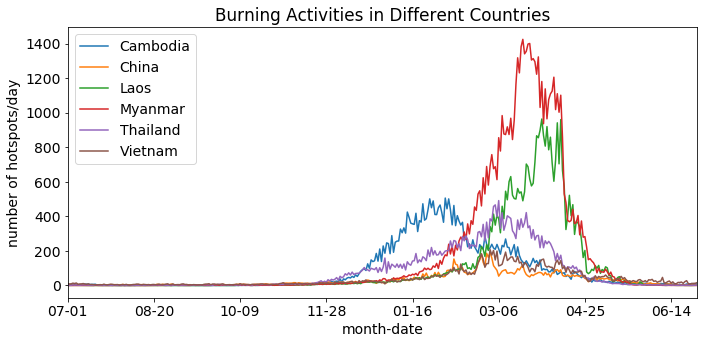

In [52]:
_, ax = plt.subplots(1,1, figsize=(10,5),sharex=True)
ax.plot(fire_country_sea)
ax.legend(fire_country_sea.columns, loc='upper left')
ax.set_title('Burning Activities in Different Countries')
ax.set_xlim([fire_country_sea.index.min(), fire_country_sea.index.max()])
new_ticks = ['07-01', '08-20', '10-09', '11-28', '01-16', '03-06', '04-25', '06-14', '']  
ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/day')
plt.tight_layout()

plt.savefig(dataset.report_folder + 'hotspots_country.png')

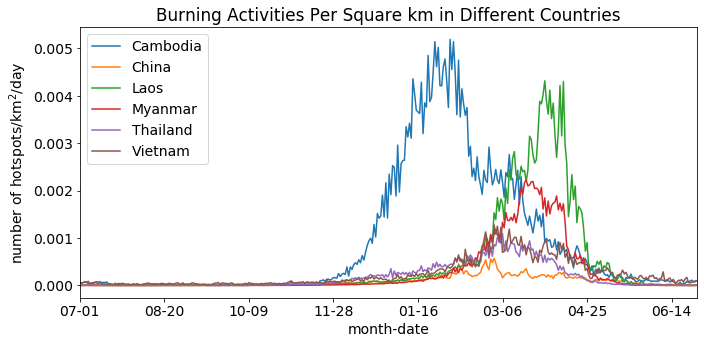

In [51]:
_, ax = plt.subplots(1,1, figsize=(10,5),sharex=True)
ax.plot(fire_country_sea/gdf['inter_area(km2)'].values)
ax.legend(fire_country_sea.columns, loc='upper left')
ax.set_title('Burning Activities Per Square km in Different Countries')
ax.set_xlim([fire_country_sea.index.min(), fire_country_sea.index.max()])
new_ticks = ['07-01', '08-20', '10-09', '11-28', '01-16', '03-06', '04-25', '06-14', '']  
ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/km$^2$/day')
plt.tight_layout()
plt.savefig(dataset.report_folder + 'hotspots_per_km2.png')

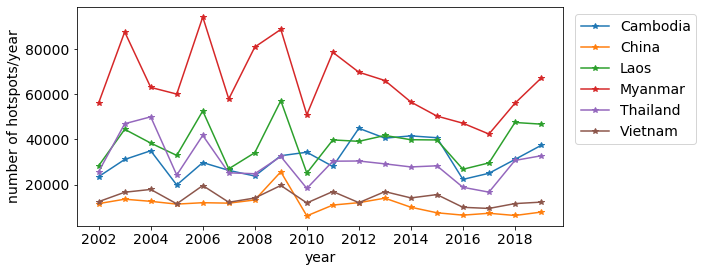

In [57]:
fire_country_year = add_season(fire_country).drop('season',axis=1)

_, ax = plt.subplots(1,1, figsize=(10,4))
fire_country_year.groupby('year').sum().drop(2020).plot(marker='*',ax=ax)
ax.set_ylabel('number of hotspots/year')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend(bbox_to_anchor=(1.01, 1))

plt.tight_layout()
plt.savefig(dataset.report_folder + 'hotspots_country_year.png')

## Landuse on the hotspots

There are three landuse data in [MODIS land cover data](https://lpdaac.usgs.gov/products/mcd12q1v006/): LC_Prop2, LC_Type1 and LC_Type5. Different systems give similar numbers of croplands, but have different value of forest vs shrubland. Here, I used LC_Type1 because it put more land into shcrubland catergories, which could means forest or crop.


I am interested in the landuse with hotspot by country or by firezone.

Here is the overall behavior. The majority is of the land are labeled forest.

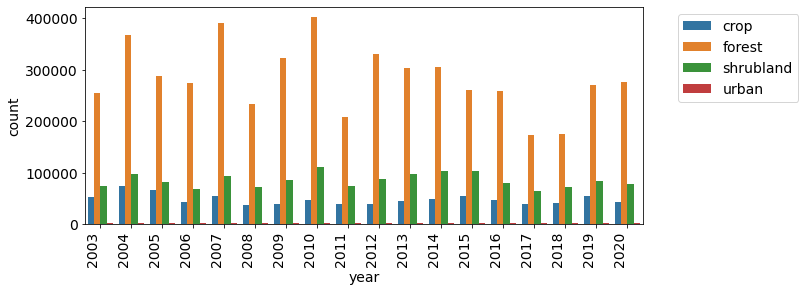

In [40]:
fire['count'] = 1
prop_type = 'LC_Type1_label'
lc_count = fire.groupby(['year', prop_type], as_index=False)['count'].count()
lc_count = lc_count[~lc_count[prop_type].isin(['water', 'unclassified'])]
lc_count = lc_count[lc_count['year'] !=2002]

_, ax = plt.subplots(1,1, figsize=(10, 4))
sns.barplot(x="year", y="count", hue=prop_type, data=lc_count, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1))

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right');

Separated by country, 

In [43]:
lc_count = fire.groupby(['year', 'country', prop_type], as_index=False)['count'].count()
lc_count = lc_count[~lc_count[prop_type].isin(['water', 'unclassified'])]
lc_count = lc_count[lc_count['year'] !=2002]

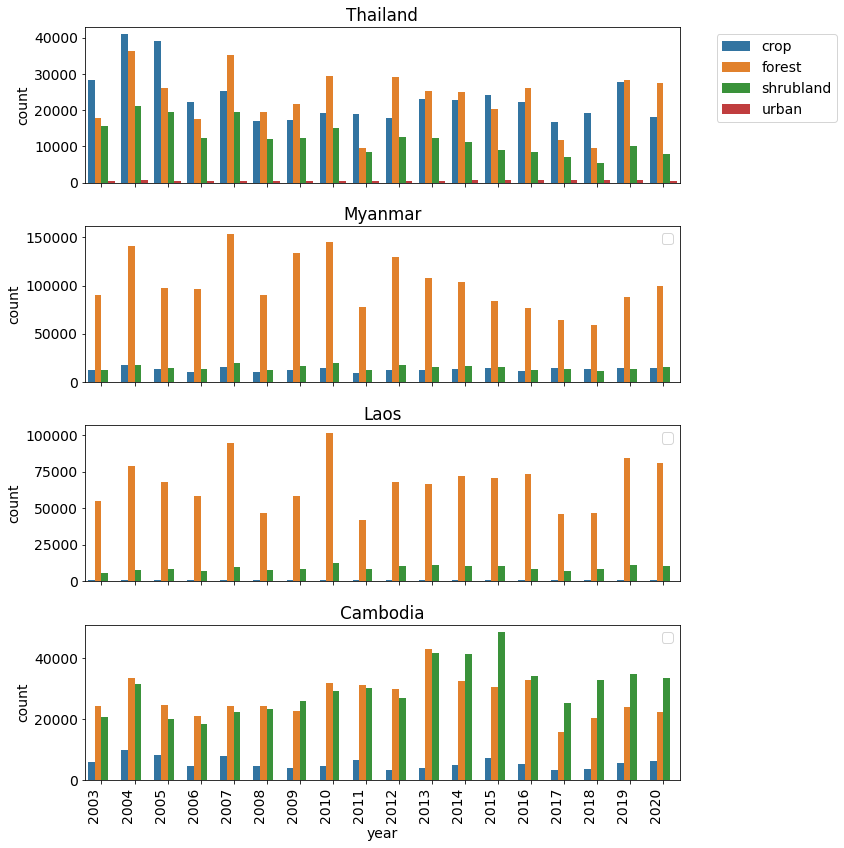

In [61]:
countries = ['Thailand', 'Myanmar', 'Laos', 'Cambodia']
len(countries)

_, ax = plt.subplots(len(countries),1, figsize=(12, 3*len(countries)), sharex=True)

for i, (a, country) in enumerate(zip(ax, countries)):
    temp = lc_count[lc_count['country'] == country]
    sns.barplot(x="year", y="count", hue=prop_type, data=temp, ax=a)
    a.set_title(country)
    if i==0:
        a.legend(bbox_to_anchor=(1.05, 1))
    else:
        a.legend([])
        
    a.set_xlabel('')

a.set_xlabel('year')
a.set_xticklabels(a.get_xticklabels(), rotation=90, ha='right');
plt.tight_layout()

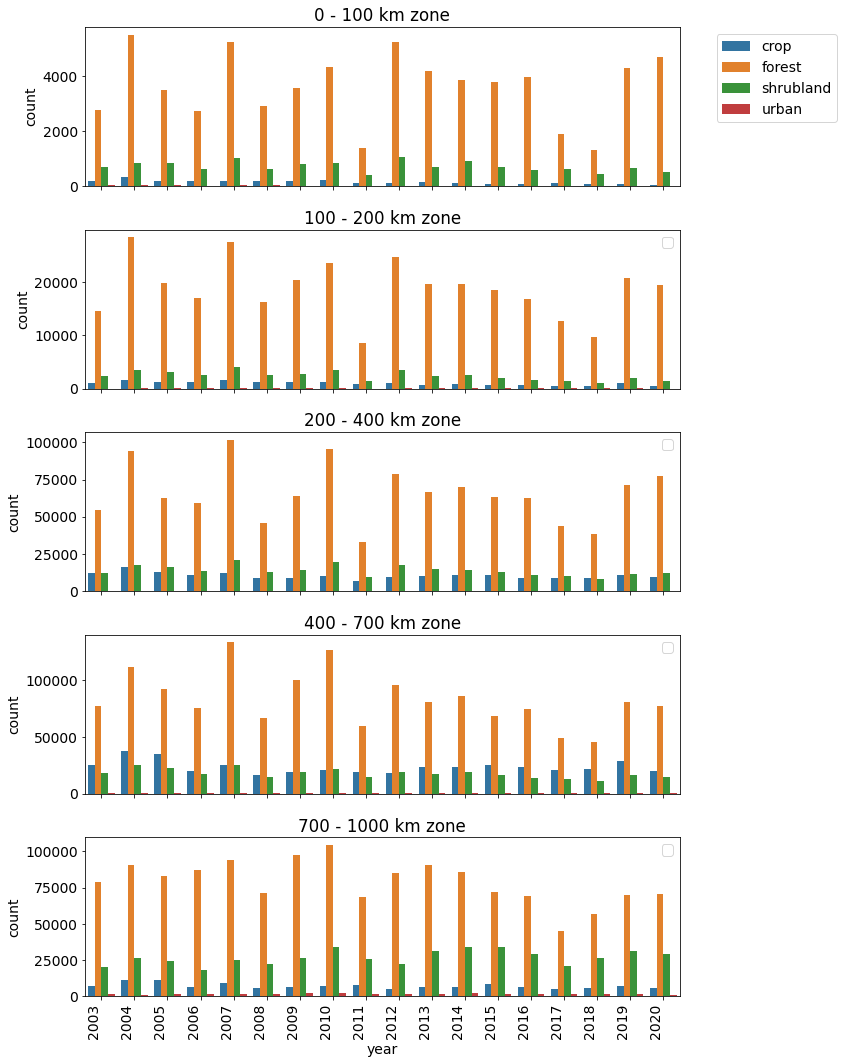

In [60]:
dataset = Dataset('Chiang Mai')
zone_list = dataset.zone_list
prop_type = 'LC_Type1_label'

_, ax = plt.subplots(len(zone_list[:-1]),1, figsize=(12, 3*len(zone_list[:-1])), sharex=True)


for i, (a, min_d, max_d) in enumerate(zip(ax, zone_list, zone_list[1:])):
    temp = fire[(fire['distance']< max_d) & (fire['distance'] >= min_d)]
    temp = temp.groupby(['year', prop_type], as_index=False)['count'].count()
    temp = temp[~temp[prop_type].isin(['water', 'unclassified'])]
    temp = temp[temp['year'] !=2002]
    
    sns.barplot(x="year", y="count", hue=prop_type, data=temp, ax=a)
    a.set_title(f'{min_d} - {max_d} km zone')
    if i==0:
        a.legend(bbox_to_anchor=(1.05, 1))
    else:
        a.legend([])
        
    a.set_xlabel('')

a.set_xlabel('year')
a.set_xticklabels(a.get_xticklabels(), rotation=90, ha='right');
plt.tight_layout()

## Amount of repeating hotspots

1. Add mercator coordinate in km 
1. Remove hotspots of the same locations within the same season.
2. Count the hotspots

In [46]:
# observing a repeating patterns 
fire = dataset.fire.copy()

fire = fire.reset_index()
# add coordinate tuple
factor = 1
fire['coor'] = [(x, y) for x, y in zip(((fire['long_km']/factor).round() *
                                        factor).astype(int), ((fire['lat_km']/factor).round()*factor).astype(int))]
# drop hotspot outside the countrires considered
fire = fire.dropna()
# round the datetime information to day
fire['datetime'] = fire['datetime'].dt.round('d')
country_list = fire['country'].unique()

In [60]:
# repeating hotspots with between year
repeat_out_year_accum = []
repeat_list = [2]
for country in country_list:
    s = cal_repeat_spots(fire[fire['country']==country].set_index('datetime').copy(),repeat_list=repeat_list,accum=True,group_list=['lat_km','long_km'])
    s.name = country 
    repeat_out_year_accum.append(s)
    
repeat_out_year_accum =   pd.concat(repeat_out_year_accum,axis=1)

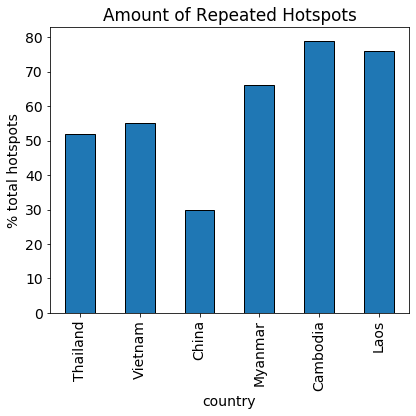

In [61]:
_, ax = plt.subplots(1,1,figsize=(6,6))

color_list = get_color(color_length=len(country_list),cmap=cm.brg)

repeat_out_year_accum.transpose().plot.bar(ax=ax, width=0.5, edgecolor='black',legend=None)


ti = 'Amount of Repeated Hotspots'

ax.set_title(ti)
ax.set_xlabel('country')
ax.set_ylabel('% total hotspots')
    
plt.tight_layout()
plt.savefig(dataset.report_folder + 'hotspots_repeat.png')

## Fire Activities Per Country Over the Year

In [4]:
# load fire data 
dataset = Dataset('Chiang Mai')
# load raw data 
dataset.load_()
fire = dataset.fire.copy()

In [6]:
# add season 
fire =  add_season(fire, start_month='-12-01', end_month='-04-30')
# remove other season
fire_analysis = fire[fire['country'] != 'other']

In [8]:
fire_analysis['country'].unique()
country = 'Thailand'

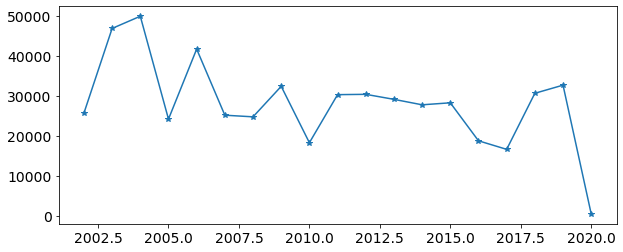

In [18]:
_, ax = plt.subplots(figsize=(10,4))

df = fire_analysis[fire_analysis['country'] == 'Thailand']
df = df.groupby('year').sum()['count']
ax.plot(df, label=country, marker='*')

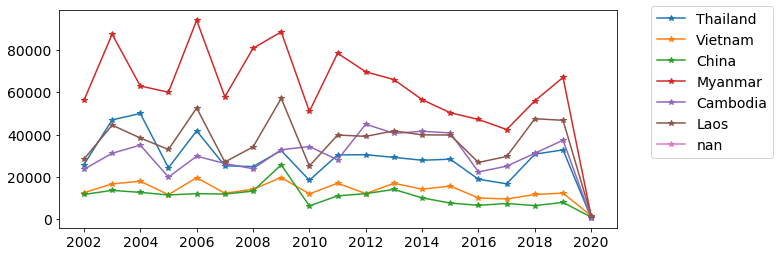

In [20]:
_, ax = plt.subplots(figsize=(10,4))

for country in fire_analysis['country'].unique():
    if country != np.nan:
        df = fire_analysis[fire_analysis['country'] == country]
        df = df.groupby('year').sum()['count']
        ax.plot(df, label=country, marker='*')

ax.legend(bbox_to_anchor=(1.05, 1.05))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))


The drops in 2011, 2016, and 2017 are observed in Thailand, Myanmar and Laos. 

Compare the seasonal pattern of the pollution and burning before and after no burning policy, which implemented for year 2017. I assume that this means starting in December 2017. 

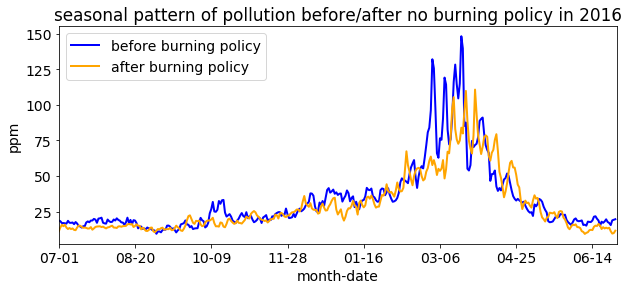

In [63]:
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.set_title('seasonal pattern of pollution before/after no burning policy in 2016')
#poll_aqi = poll_to_aqi(data.poll_df.copy(), data.roll_dict)
winter_day_dict, mean_day = plot_season_avg(dataset.poll_df.loc[:'2015-06-01'], 'PM2.5', ax, plot_error=False, roll=True, agg='mean',linewidth=2 )

ax.set_ylabel('ppm')
fire_hour = dataset.fire[['count']].resample('d').sum()
fire_hour.columns = ['number of hotspots']

winter_day_dict, mean_day = plot_season_avg(dataset.poll_df.loc['2016-06-01': ], 'PM2.5', ax, plot_error=False, roll=True, agg='mean',linewidth=2, color='orange')

ax.legend(['before burning policy', 'after burning policy'])

Text(0, 0.5, 'number of hotspot')

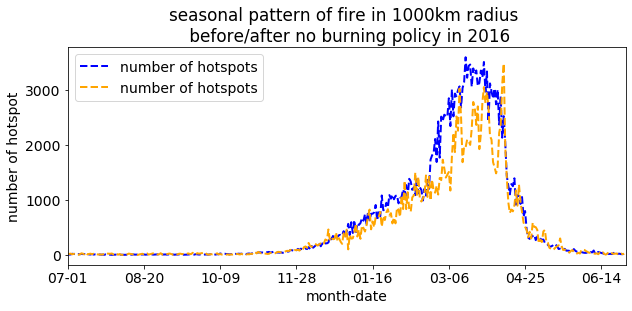

In [62]:
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.set_title('seasonal pattern of fire in 1000km radius \n before/after no burning policy in 2016')

temp = dataset.fire[['count', 'country', 'distance']]
#temp = temp[temp['distance'] <= 500]
fire_hour = temp.resample('d').sum()[['count']]
fire_hour.columns = ['number of hotspots']
winter_day_dict, fire_mean_day = plot_season_avg(fire_hour.loc[:'2015-06-01'], 'number of hotspots', ax, plot_error=False, roll=False, agg='mean',color='blue',linestyle='dashed',linewidth=2)

winter_day_dict, fire_mean_day = plot_season_avg(fire_hour.loc['2016-06-01':], 'number of hotspots', ax, plot_error=False, roll=False, agg='mean',color='orange',linestyle='dashed',linewidth=2)

ax.legend(['before burning policy', 'after burning policy'], loc='upper left')
ax.set_ylabel('number of hotspot')

Text(0, 0.5, 'number of hotspot')

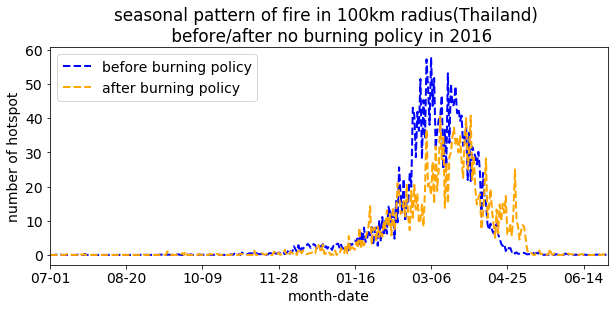

In [64]:
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.set_title('seasonal pattern of fire in 100km radius(Thailand) \n before/after no burning policy in 2016')

temp = dataset.fire[['count', 'country', 'distance']]
temp = temp[temp['distance'] <= 100]
fire_hour = temp.resample('d').sum()[['count']]
fire_hour.columns = ['number of hotspots']
winter_day_dict, fire_mean_day = plot_season_avg(fire_hour.loc[:'2015-06-01'], 'number of hotspots', ax, plot_error=False, roll=False, agg='mean',color='blue',linestyle='dashed',linewidth=2)

winter_day_dict, fire_mean_day = plot_season_avg(fire_hour.loc['2016-06-01':], 'number of hotspots', ax, plot_error=False, roll=False, agg='mean',color='orange',linestyle='dashed',linewidth=2)

ax.legend(['before burning policy', 'after burning policy'], loc='upper left')
ax.set_ylabel('number of hotspot')